In [1]:
using Pkg
using Revise
using Plots


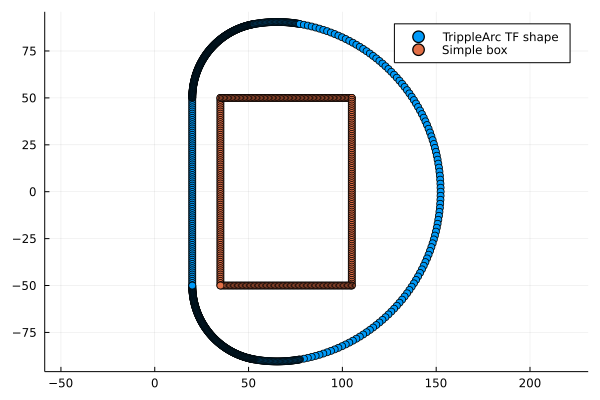

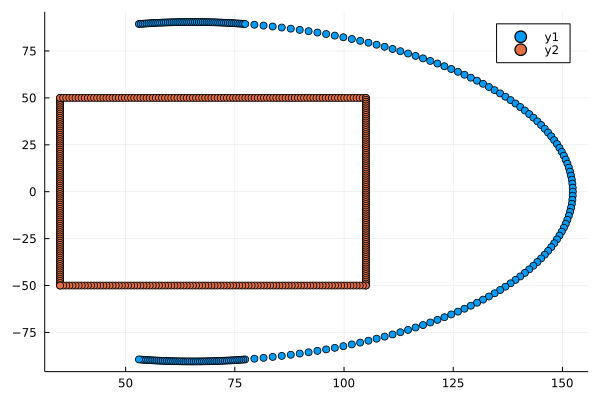

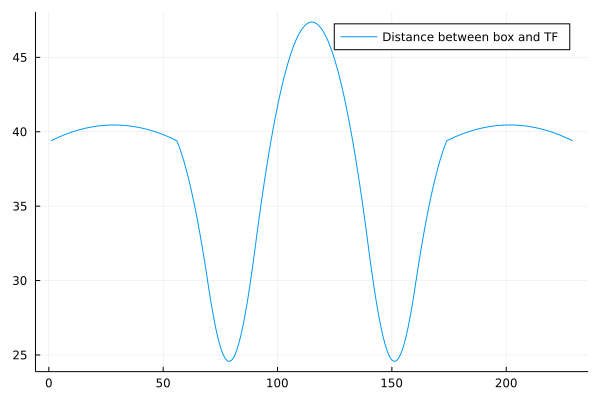

In [15]:
function TrippleArc(;R1::Real, h::Real, small_radius::Real, mid_radius::Real, small_coverage::Real, mid_coverage::Real, resolution_points=1000, return_starting_points=false)    
    small_coverage *= pi / 180  # convert to radians
    mid_coverage *= pi / 180
    h *= 0.5 # Half height for each side
    asum = small_coverage + mid_coverage
    
    # small arc
    theta = LinRange(
        0, small_coverage, round(Int64,0.5 * resolution_points * small_coverage / pi))
    small_arc_R = R1 .+ small_radius .* (1 .- map(cos,theta))
    small_arc_Z = h .+ small_radius .* map(sin,theta)
    shape_POI = [(small_arc_R[end],small_arc_Z[end])]
    # mid arc
    theta = LinRange(
        theta[end], asum, round(Int64,0.5 * resolution_points * mid_coverage / pi))
    mid_arc_R = small_arc_R[end] .+ mid_radius .* 
        (map(cos,small_coverage) .- map(cos,theta))
        mid_arc_Z = small_arc_Z[end] .+ mid_radius * 
        (map(sin,theta) .- map(sin,small_coverage))
    shape_POI = vcat(shape_POI,(mid_arc_R[end],mid_arc_Z[end]))
    # large arc
    large_radius = (mid_arc_Z[end]) / sin(pi - asum)
    theta = LinRange(theta[end], pi, 60)
    large_arc_R = mid_arc_R[end] .+ large_radius .* 
        (map(cos,pi .- theta) .- map(cos,pi .- asum))
        large_arc_Z = mid_arc_Z[end] .- large_radius .* 
        (sin(asum) .- map(sin, pi .- theta))

    shape_POI = vcat(shape_POI,(large_arc_R[end],large_arc_Z[end]))

    R = vcat(small_arc_R, mid_arc_R[2:end], large_arc_R[2:end])
    R = vcat(R,reverse(R)[2:end])
    Z = vcat(small_arc_Z, mid_arc_Z[2:end], large_arc_Z[2:end])
    Z = vcat(Z, -reverse(Z)[2:end])
    
    # Add vertical
    n_points_box = 100
    R = vcat(LinRange(R1, R1, n_points_box), R)
    Z = vcat(LinRange(-h, h ,n_points_box), Z)
    
    shape_POI = vcat(shape_POI,(R[1],Z[1]), (R[n_points_box],Z[n_points_box]))
    if return_starting_points
        return shape_POI, R, Z
    else
        return R,Z
        end
    end

function minimum_distance_two_objects(R_obj1, Z_obj1, R_obj2, Z_obj2)
    min_distance_array = zeros(0)
    for (r_1, z_1) in zip(R_obj1,Z_obj1)
        distance = zeros(0)
        for (r_2, z_2) in zip(R_obj2, Z_obj2)
            append!(distance, sqrt((r_1 - r_2)^2 + (z_1 - z_2)^2))
            end
        append!(min_distance_array,minimum(distance))
        end
    return min_distance_array
    end

function quick_box(width::Real,height::Real, r_center::Real)
    r_start = r_center - 0.5 * width
    r_end = r_center + 0.5 * width
    z_start = - 0.5 * height 
    z_end = 0.5 * height
    n_points = 100
    R_box = vcat(LinRange(r_start,r_start,n_points),LinRange(r_start,r_end,n_points),LinRange(r_end,r_end,n_points),LinRange(r_end,r_start,n_points))
    Z_box = vcat(LinRange(z_start,z_end,n_points),LinRange(z_end,z_end,n_points),LinRange(z_end,z_start,n_points),LinRange(z_start,z_start,n_points))
    return R_box, Z_box
    end

# Initial TF Tripple arc shape and "box"
starting_points, R_TF, Z_TF = TrippleArc(R1=20, h=100, small_radius=40, mid_radius=70, small_coverage=80, mid_coverage=20, return_starting_points=true)
scatter(R_TF, Z_TF, aspect_ratio=:equal, label="TrippleArc TF shape")
R_box , Z_box = quick_box(70,100,70)
display(scatter!(R_box , Z_box, label="Simple box"))

scatter!(starting_points[1])
scatter!((starting_points[1][1],-starting_points[1][2]))
TF_opt_start, TF_opt_end  = findall(x-> x == starting_points[1][1], R_TF)

# Minimum distance between object and TF
scatter(R_TF[TF_opt_start:TF_opt_end],Z_TF[TF_opt_start:TF_opt_end])
display(scatter!(R_box , Z_box))
display(plot(minimum_distance_two_objects(R_TF[TF_opt_start:TF_opt_end], Z_TF[TF_opt_start:TF_opt_end],R_box, Z_box), label="Distance between box and TF"))

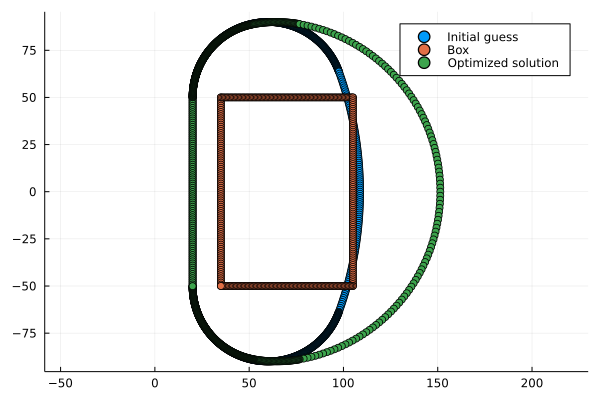

Optimized height solution cost 10.015062738130752Target R_end 130 , found R_end 151.36722722592356


In [71]:
# Optimization of shape to match minimum distance target, R_end and minimize length TF
using Optim
function cost_TF_shape(initial_guess,distance_target,R_end_target,length_cost, doPlot=false)
    starting_points, R_TF, Z_TF = TrippleArc(R1=20, h=initial_guess[1], small_radius=40, mid_radius=initial_guess[2], small_coverage=initial_guess[3], mid_coverage=90, return_starting_points=true)
    R_box , Z_box = quick_box(70,100,70)

    if doPlot
        scatter(R_TF, Z_TF,label="Initial guess", aspect_ratio=:equal)
    end
    TF_opt_start, TF_opt_end  = findall(x-> x == starting_points[1][1], R_TF)
    coil_length = sum(sqrt.((R_TF[1:end-1] .- R_TF[2:end]).^2 + (Z_TF[1:end-1] .- Z_TF[2:end]).^2))
    
    cost = 0
    # Minimum distance
    cost += (minimum(minimum_distance_two_objects(R_TF[TF_opt_start:TF_opt_end], Z_TF[TF_opt_start:TF_opt_end],R_box, Z_box)) - min_distance_target)^2
#    cost += (minimum(minimum_distance_two_objects(R_TF, Z_TF,R_box, Z_box)) - min_distance_target)^2
#    println(coil_length)


    # Coil length
    if length_cost
        cost += coil_length/100
    end
    # R_end location
#    cost += 10*(maximum(R_TF)- R_end_target)^2

    return sqrt(cost)
end

# Optimization targets 
distance_target=10.0
R_end_target = 130
length_cost = true

initial_guess= [100.0,40.0,70.0,80.0,20.0]
cost_TF_shape(initial_guess,distance_target,R_end_target,length_cost, true)
scatter!(R_box,Z_box,aspect_ratio=:equal, label="Box")
Sol = optimize(initial_guess-> cost_TF_shape(initial_guess,distance_target, R_end_target,length_cost),initial_guess, GradientDescent(), Optim.Options(time_limit=100, g_tol=1e-8))

optimized = Optim.minimizer(Sol)
R_TF, Z_TF = TrippleArc(R1=20, h=optimized[1], small_radius=optimized[2], mid_radius=optimized[3], small_coverage=optimized[4], mid_coverage=optimized[5])

display(scatter!(R_TF, Z_TF, label="Optimized solution"))

print("Optimized height solution cost " ,cost_TF_shape(initial_guess,distance_target, R_end_target,length_cost))
println("Target R_end $R_end_target , found R_end $(maximum(R_TF))")

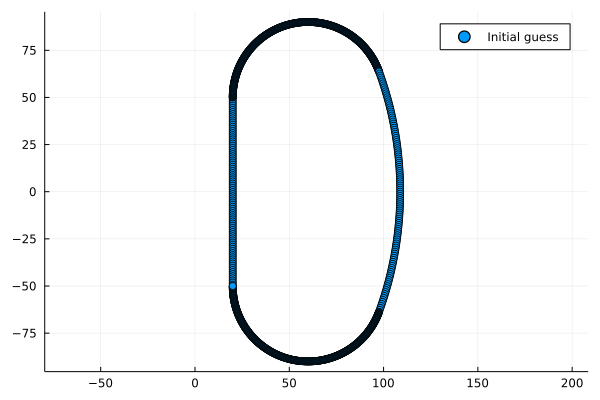

83.37627594955113